In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/figshare-dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.transforms import Compose, ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('figshare-dataset', output = 'figshare-split' , seed = 1337, ratio = (0.7,0.1,0.2))

Copying files: 3064 files [00:00, 5497.77 files/s]


In [ ]:
train_path = 'figshare-split/train'
val_path = 'figshare-split/val'
test_path = 'figshare-split/test'

In [ ]:
transform = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor()
    ]
)

In [ ]:
image_datasets = {x: torchvision.datasets.ImageFolder(eval(f"{x}_path"), transform) for x in ['train', 'val','test']}

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val','test']}

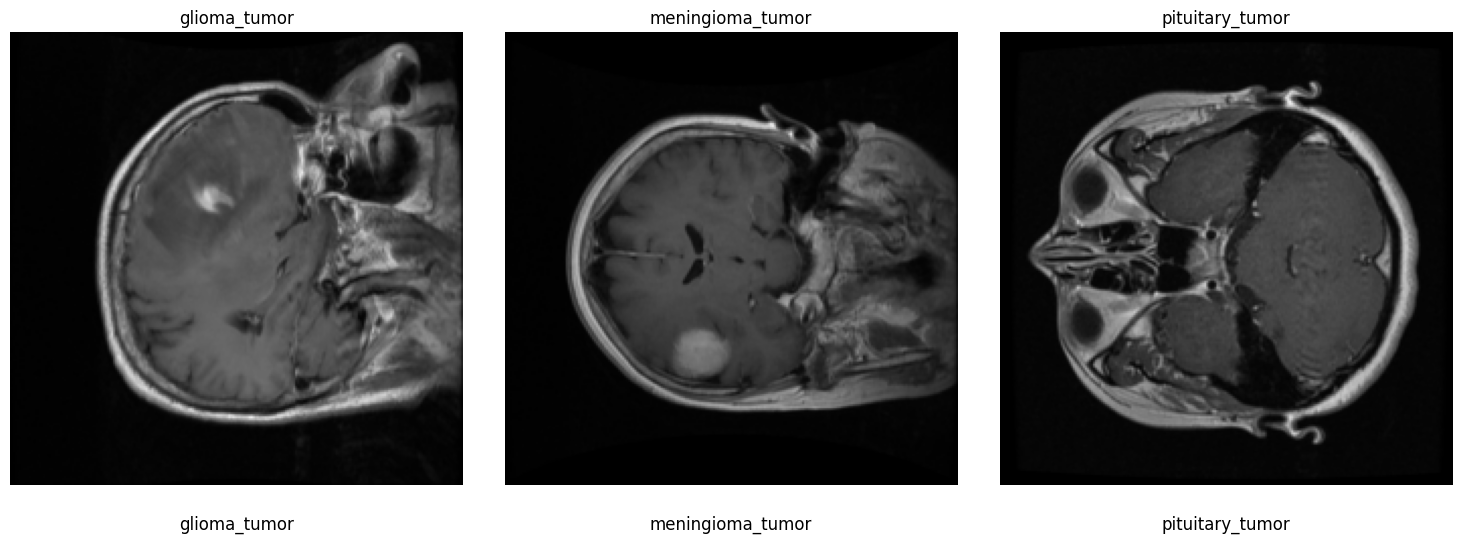

In [ ]:
def visualize_class_samples(dataset):
    classes = dataset.classes

    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

    # Loop through each class
    for i, cls in enumerate(classes):
        indices = np.where(np.array(dataset.targets) == i)[0]  # Indices of samples in this class
        selected_idx = np.random.choice(indices, size=1, replace=False)[0]  # Choose one image index

        image, _ = dataset[selected_idx]
        ax = axes[i]
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Transpose to (H, W, C)
        ax.set_title(cls)
        ax.axis('off')

        ax.text(0.5, -0.1, cls, transform=ax.transAxes, fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

visualize_class_samples(image_datasets['train'])

In [ ]:
vgg16_model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:29<00:00, 19.1MB/s]


In [ ]:
num_classes = len(image_datasets['train'].classes)
print(num_classes)

3


In [ ]:
print(vgg16_model.features[28])

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
vgg16_model.classifier[3] = nn.Dropout(0.5)
vgg16_model.classifier[6] = nn.Sequential(
    nn.Linear(vgg16_model.classifier[6].in_features, 4096),
    nn.ReLU(inplace=False),
    nn.Dropout(0.5, inplace=False),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes),
)

for param in vgg16_model.features.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
vgg16_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 20

In [ ]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
true_labels = []
predicted_labels = []

In [ ]:
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16_model.train()
        else:
            vgg16_model.eval()

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16_model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_accuracy = correct / total

        print(f'{phase.capitalize()} Epoch {epoch + 1}/{num_epochs}, '
              f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Collect losses and accuracies for plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
        else:
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_accuracy)

    scheduler.step()

Train Epoch 1/20, Loss: 0.8176, Accuracy: 0.6287
Val Epoch 1/20, Loss: 0.3840, Accuracy: 0.8230
Train Epoch 2/20, Loss: 0.4296, Accuracy: 0.8218
Val Epoch 2/20, Loss: 0.2884, Accuracy: 0.8623
Train Epoch 3/20, Loss: 0.3773, Accuracy: 0.8433
Val Epoch 3/20, Loss: 0.2964, Accuracy: 0.8689
Train Epoch 4/20, Loss: 0.3337, Accuracy: 0.8680
Val Epoch 4/20, Loss: 0.2270, Accuracy: 0.9082
Train Epoch 5/20, Loss: 0.2923, Accuracy: 0.8811
Val Epoch 5/20, Loss: 0.2134, Accuracy: 0.9082
Train Epoch 6/20, Loss: 0.2660, Accuracy: 0.8946
Val Epoch 6/20, Loss: 0.1900, Accuracy: 0.9279
Train Epoch 7/20, Loss: 0.2125, Accuracy: 0.9156
Val Epoch 7/20, Loss: 0.2019, Accuracy: 0.9344
Train Epoch 8/20, Loss: 0.2061, Accuracy: 0.9207
Val Epoch 8/20, Loss: 0.1844, Accuracy: 0.9344
Train Epoch 9/20, Loss: 0.1867, Accuracy: 0.9268
Val Epoch 9/20, Loss: 0.1820, Accuracy: 0.9377
Train Epoch 10/20, Loss: 0.1805, Accuracy: 0.9258
Val Epoch 10/20, Loss: 0.1744, Accuracy: 0.9377
Train Epoch 11/20, Loss: 0.1808, Accur

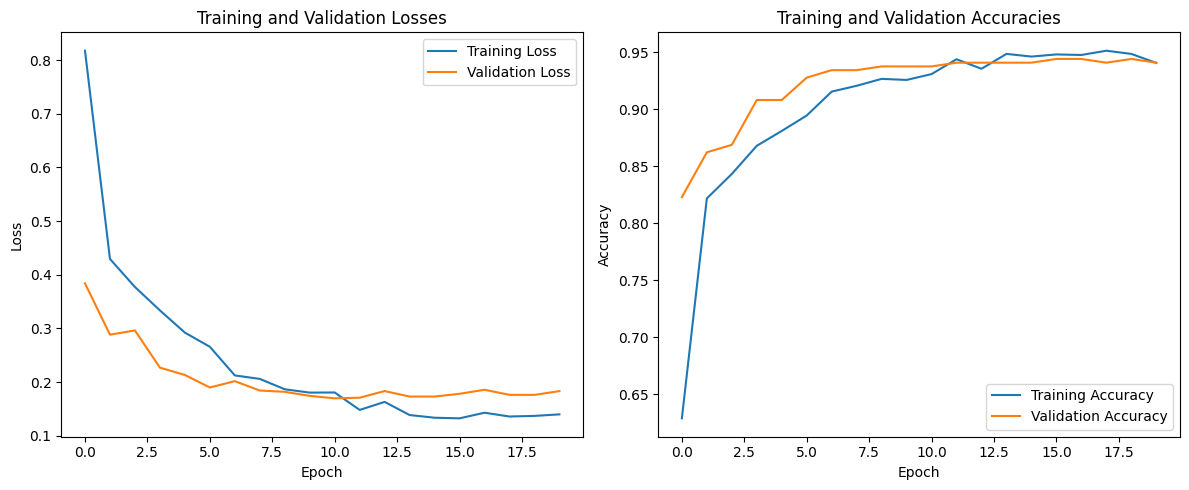

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Call the function to get the test accuracy
test_accuracy = evaluate_test_accuracy(vgg16_model, dataloaders['test'])
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9073


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

class_names = ['Glioma', 'Meningioma', 'Pituitary']

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print(true_labels.shape)
print(predicted_labels.shape)

report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print or use the classification report
print(report)


(48980,)
(48980,)
              precision    recall  f1-score   support

      Glioma       0.92      0.93      0.92     22800
  Meningioma       0.83      0.79      0.81     11300
   Pituitary       0.94      0.96      0.95     14880

    accuracy                           0.91     48980
   macro avg       0.90      0.89      0.89     48980
weighted avg       0.90      0.91      0.91     48980



In [ ]:
def predict_class(image_path):
    # Load an image
    image = Image.open(image_path).convert('RGB')


    # Preprocess the image
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Move the input tensor to the appropriate device

    # Perform prediction
    with torch.no_grad():
        output = vgg16_model(input_batch)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()


In [ ]:
image_path = '/content/figshare-split/train/pituitary_tumor/1453.png'  # Replace with the actual image path
predicted_class = predict_class(image_path)

class_names = ['Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

print(f'Predicted Class: {class_names[predicted_class]}')

Predicted Class: Pituitary Tumor


In [ ]:
num_trainable_params = sum(p.numel() for p in vgg16_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_trainable_params}')

Number of trainable parameters: 151054147


In [ ]:
!pip install grad-cam

In [ ]:
for param in vgg16_model.features.parameters():
    param.requires_grad = True

In [ ]:
def ReLU_inplace_to_False(module):
    for layer in module._modules.values():
        if isinstance(layer, nn.ReLU):
            layer.inplace = False
        ReLU_inplace_to_False(layer)
ReLU_inplace_to_False(vgg16_model)

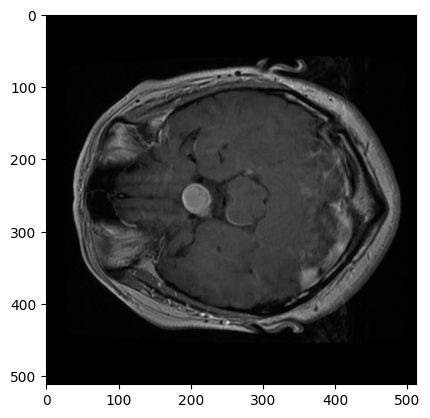

In [ ]:
plt.imshow(Image.open(image_path).convert('RGB'))

In [ ]:
print(vgg16_model)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [ ]:
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image)
input_tensor.unsqueeze_(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [vgg16_model.features[28]]

In [ ]:
cam = GradCAM(model=vgg16_model, target_layers=target_layers)

In [ ]:
targets = [ClassifierOutputTarget(2)] #class label

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
#visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [ ]:
print(input_tensor.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
print(grayscale_cam.shape)

(224, 224)


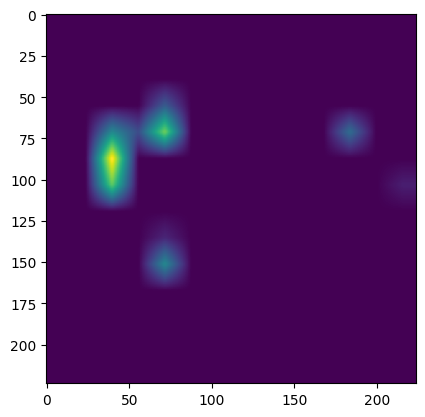

In [ ]:
plt.imshow(grayscale_cam)

In [ ]:
import cv2

In [ ]:
image_array = np.array(image)/255

In [ ]:
resized_heatmap = cv2.resize(grayscale_cam, (image_array.shape[1], image_array.shape[0]))

In [ ]:
visualization = show_cam_on_image(image_array, resized_heatmap, use_rgb=True)

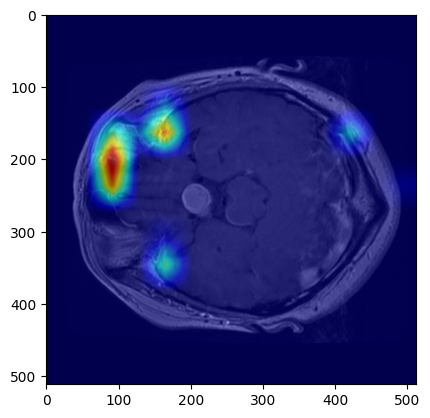

In [ ]:
plt.imshow(visualization)